In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader,random_split
import torch.nn as nn
from pyflann import *
import torchvision.models as models
import torchvision
from torchvision import transforms
import matplotlib.image as mpimg
import pickle
import json
import time
from copy import deepcopy
import matplotlib.pyplot as plt
from celery import group
from imagesearch_workers import upload_data, imagesearch_tasks, NumpyEncoder

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [4]:
o_model = models.vgg16(pretrained=True)
img_transfrom = transforms.Compose(
                [   transforms.Resize((224, 224)),
                    transforms.ToTensor(), 
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                ])
dataset = ImageFolderWithPaths('./data/101_ObjectCategories/',transform=img_transfrom)
print('Dataset size: {}'.format(len(dataset)))

Dataset size: 9144


In [5]:
# dataloader = DataLoader(dataset,batch_size=128,shuffle=True)

In [6]:
print(o_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
class Flatten_Layer(nn.Module):
    def forward(self, x):
        batch_size, ch, height, width = x.size()
        return x.view(batch_size, -1)

conv,linear = list(o_model.children())
linear = linear[:-2]
model = torch.nn.Sequential(*[conv,Flatten_Layer(),linear])
model(dataset[0][0].unsqueeze_(0)).size()

torch.Size([1, 4096])

(array([3.463e+03, 1.950e+02, 1.470e+02, 1.140e+02, 8.500e+01, 4.000e+01,
        2.200e+01, 2.000e+01, 7.000e+00, 3.000e+00]),
 array([0.        , 0.47368488, 0.94736975, 1.4210546 , 1.8947395 ,
        2.3684244 , 2.8421092 , 3.3157942 , 3.789479  , 4.263164  ,
        4.736849  ], dtype=float32),
 <a list of 10 Patch objects>)

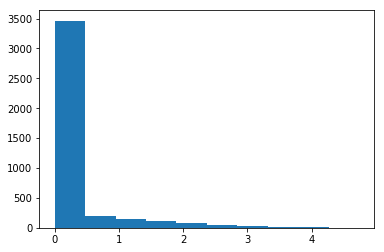

In [8]:
output = model(dataset[0][0].unsqueeze_(0)).detach().numpy()
plt.hist(output.ravel())

In [9]:
train_data_size = 9000
test_data_size = len(dataset) - train_data_size
train_dataset, test_dataset = random_split(dataset,[train_data_size,test_data_size])

In [10]:
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


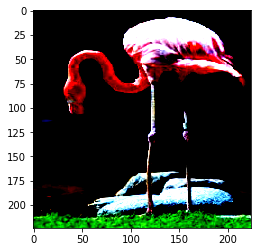

In [11]:
query_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=True)
query_img = iter(query_dataloader)
q_img,label,path = query_img.next()
plt.imshow(np.transpose(q_img.detach().numpy().squeeze(),(1,2,0)))

In [12]:
q_img_vector = model(q_img.to(DEVICE))

In [14]:
images=[]
model = model.to(DEVICE)
if not os.path.isfile('./results/high_dim_features_caltech101.pickle'): #set this to zero if you only did this calculation and just want to load it.
    features = []
    for index, (image,label,path) in enumerate(train_dataloader):
        if index % 19 == 0:
            print(index+1)
        image = image.to(DEVICE)
        feature = model(image).detach().cpu().numpy().squeeze()
        assert(feature.shape[-1]==4096)
        features.extend(feature)
        path = images.extend(path)
        torch.cuda.empty_cache()
    pickle.dump([features,images], open('./results/high_dim_features_caltech101.pickle', 'wb'))
else:
    print('Load from file')
    features,images = pickle.load(open('./results/high_dim_features_caltech101.pickle', 'rb'))
    pass

Load from file


In [15]:
mydata= {"features": np.array(features).tolist(), "path": images}

In [16]:
# We will use four workers
n_workers = 4
# Let us split the train set to four parts. Each part will be uploaded to one of the four workers.
l = train_data_size // n_workers
print(l)
mydata_to_workers = [{"features":mydata['features'][i * l:(i + 1) * l],
                     "path":mydata['path'][i * l:(i + 1) * l],
                     } for i in range(n_workers)]

2250


## Upload data

In [18]:
# start dispatch
start_upload_time = time.time()
group_upload = group(upload_data.s(json_dump=json.dumps(mydata_to_workers[i], cls=NumpyEncoder)) for i in range(n_workers))()
get_ready_list = group_upload.get()
print('Upload time usage:{}s'.format(time.time() - start_upload_time))

Upload time usage:20.99272847175598s


## Query

In [19]:
query = {'query_feature':q_img_vector.cpu().detach().numpy().tolist()}
group_query = group(imagesearch_tasks.s(json_dump=json.dumps(query,cls=NumpyEncoder)) for _ in range(n_workers))()
query_results= group_query.get()
linear_time = []
kdtree_time = []
query_result = []
for row in query_results:
    query_result.append(row[0])
    linear_time.append(row[1])
    kdtree_time.append(row[2])
query_result = np.asarray(query_result)

### Query data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


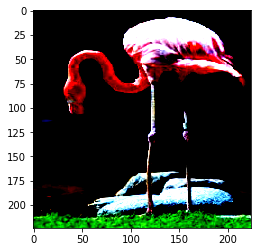

In [20]:
plt.imshow(np.transpose(q_img.detach().numpy().squeeze(),(1,2,0)))

### Retrieved Data

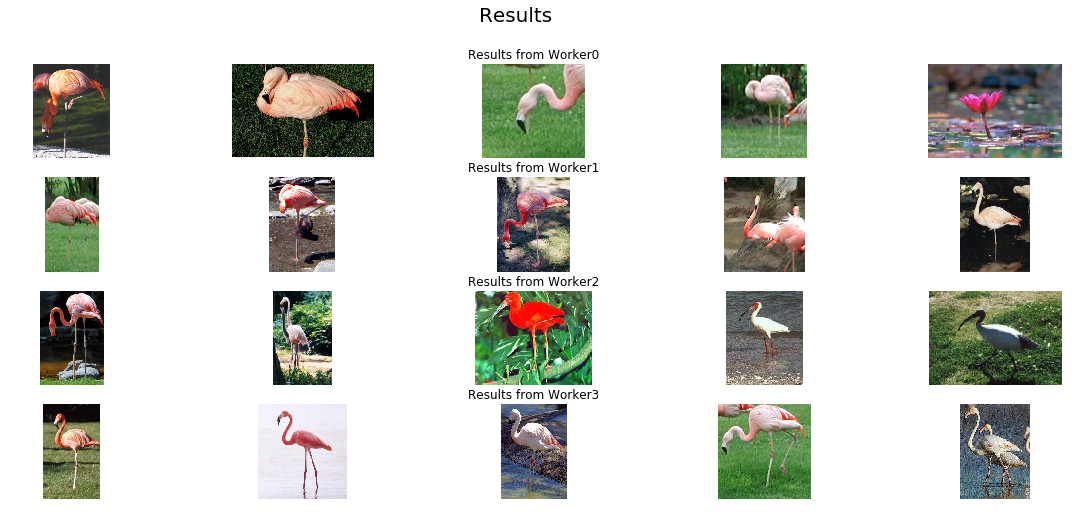

In [21]:
fig, axes = plt.subplots(n_workers,query_result.shape[-1],figsize=(n_workers*5,n_workers*2))
fig.suptitle('Results',fontsize=20)
for i,path_list in enumerate(query_result):
    for j in range(len(path_list)):
        if j == (query_result.shape[-1] + 1)//2 -1:
            axes[i,j].set_title('Results from Worker{}'.format(i))
        axes[i,j].imshow(mpimg.imread(path_list[j]))
        axes[i,j].axis('off')
plt.show()

In [22]:
for worker_id in range(len(linear_time)):
    print('Worker{} (\'kdtree\':{})(\'Naive\':{})'.format(worker_id,kdtree_time[worker_id],linear_time[worker_id]))

Worker0 ('kdtree':1.0402348041534424)('Naive':2.184357166290283)
Worker1 ('kdtree':1.048168659210205)('Naive':2.1522889137268066)
Worker2 ('kdtree':1.1321337223052979)('Naive':2.200138568878174)
Worker3 ('kdtree':0.9681727886199951)('Naive':2.2248098850250244)
